## Workflow
- Create a reasonable neuron population
 - optimize twiddle bits from calibration data
- Collect tuning to check neuron reasonability
- Collect and filter spikes at 0 input
- Turn off neurons whos spike rates are higher than 6 / tau_syn 

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
from nengo_extras.plot_spikes import plot_spikes

import pystorm
from pystorm.hal import HAL
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

In [2]:
def get_snr_gamma(lamtau_out, k):
    """SNR of the synaptically filtered gamma process

    In terms of the output lambda * tau
    """
    if isinstance(lamtau_out, float):
        lamtau_out = np.array([lamtau_out])
    lamtau_in = lamtau_out * k
    snr = np.zeros_like(lamtau_out)
    idx = lamtau_out > 0
    x = lamtau_in
    a = np.sqrt(2*x[idx])
    b_num = (1+x[idx])**k+x[idx]**k
    b_den = (1+x[idx])**k-x[idx]**k
    b = b_num/b_den
    c = 2*x[idx]/k
    snr[idx] = a / np.sqrt(k*(b-c))
    return snr

def get_snr_periodic(lamtau):
    snr = np.zeros_like(lamtau)
    idx = lamtau > 0
    snr[idx] = 1./np.sqrt(
        1./(2.*lamtau[idx])*(1+np.exp(-1/(lamtau[idx])))/(1-np.exp(-1/(lamtau[idx])))-1)
    return snr

def check_decode(decode):
    """Check that decode data is reasonable"""
    bins_gt0 = np.sum(decode>0)
    total_outputs = np.sum(decode)
    bins_1 = np.sum(decode==1)
    bins_2 = np.sum(decode==2)
    bins_gt2 = np.sum(decode>2)
    bin_vals_gt2 = np.unique(decode[decode>2])
    print("Collected {:d} non-zero output bins. Sum(outputs) = {:d}".format(bins_gt0, total_outputs))
    print("Bin stats:1-spike bins: {:d}, 2-spike bins: {:d}, >2-spike bins: {:d} (bin values {})".format(
        bins_1, bins_2, bins_gt2, bin_vals_gt2))

In [3]:
# set parameters for network
X = 10
Y = 10
NNEURON = X*Y
DIM = 1
DOWNSTREAM_NS = 10000
UPSTREAM_NS   = 100000
PS = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = 1,
)
DACS_OPT = {'DAC_SOMA_REF':1024} # dac values for optimizer

In [4]:
hal = HAL()
net_builder = NetBuilder(hal)
calibrator = Calibrator(hal)

In [5]:
def build_tuning_net(ps_orig, net_builder, calibrator):
    d_matrix = np.eye(np.prod(ps_orig.YX))
    p_fname = (ps_orig.label + "_" + str(ps_orig.YX) + "_" +
               str(ps_orig.loc_yx) + "_" + str(ps_orig.D) + ".pck")
    try:
        with open(p_fname, 'rb') as f:
            ps = pickle.load(f)
    except:
        ps, dac, est_enc, est_off, dbg = calibrator.optimize_yield(ps_orig, DACS_OPT)
        with open(p_fname, 'wb') as f:
            pickle.dump(ps, f)
    net = net_builder.create_single_pool_net_from_spec(ps, d_matrix)
    return net

def assign_decoders(net, decoders, hal):
    net.decoder_conn.weights[-1, :] = decoders
    net.decoder_conn.reassign_weights(net.decoder_conn.weights)
    hal.remap_weights()

net = build_tuning_net(PS, net_builder, calibrator)
run_control = RunControl(hal, net)
hal.map(net)

Collect spikes at 0 input

In [6]:
#  deliver an input of 0
def run_spikes_test(hal, run_control, bin_size_ns=100000):
    """Run a single input test trial"""
    hal.set_time_resolution(DOWNSTREAM_NS, bin_size_ns)
    
    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns

    input_vals = {net.input:(input_times, input_rates)}
    
#     output_data, _ = run_control.run_input_sweep(
#         input_vals, get_raw_spikes=False, get_outputs=True)
#     outputs, bin_times_ns = output_data
#     spikes = outputs[net.output]

    _, spike_data = run_control.run_input_sweep(
        input_vals, get_raw_spikes=True, get_outputs=False)
    spikes, bin_times_ns = spike_data
    spikes = spikes[net.pool]
    
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return spikes, bin_times
spikes, bin_times = run_spikes_test(hal, run_control)
# if np.sum(spikes[0]) > 2*spikes.shape[1]: # zero-out spikes that accumulated between traffic activation and exp
#     spikes[0] = 0

In [7]:
dt = bin_times[1] - bin_times[0]
tau = 0.01
filtered_spikes = lpf(spikes, tau, dt)
spike_rates = np.sum(spikes, axis=0) / (bin_times[-1] - bin_times[0])

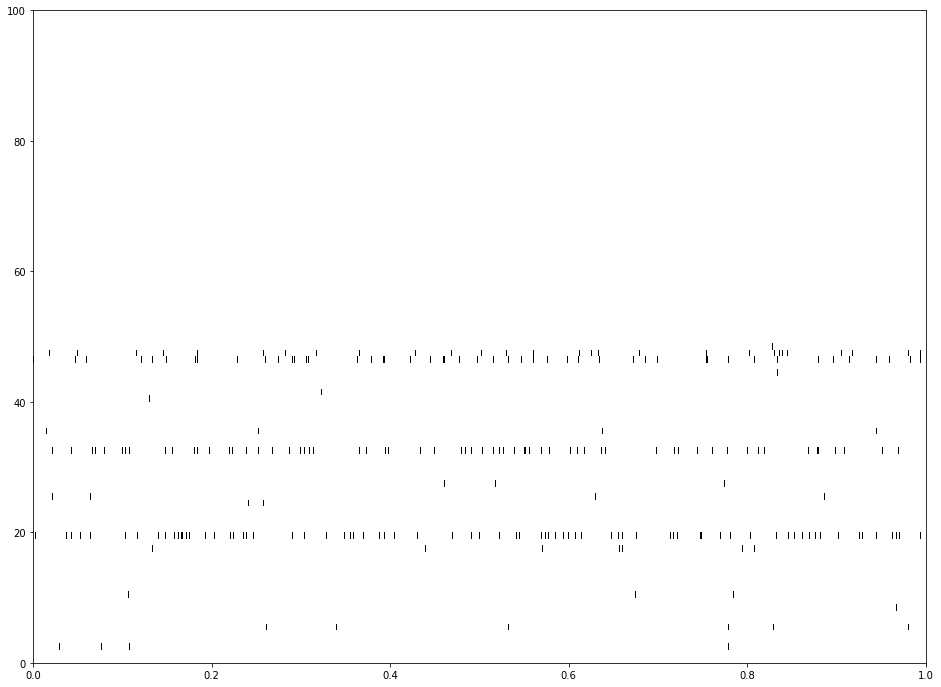

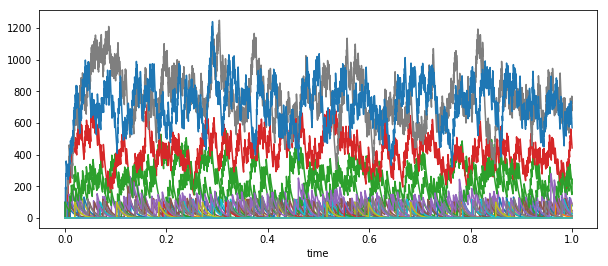

In [8]:
# make a raster of spikes
def plot_spike_raster_filter(spikes, filtered_spikes, bin_times):
    to_raster = spikes.copy()
    to_raster[to_raster>1] = 1
    plt.subplots(figsize=(16, 12))
    plot_spikes(bin_times, to_raster)

    plt.subplots(figsize=(10,4))
    for idx in range(X*Y):
        plt.plot(bin_times, filtered_spikes[:, idx])
    plt.xlabel("time")
plot_spike_raster_filter(spikes, filtered_spikes, bin_times)

Some neurons are spiking very fast relative to the filter time constant. For the theory to align well with the experiment, we want $\lambda\tau<1$ and ideally $\lambda\tau<\frac{1}{6}$.

Find the neurons with high spike rates and set them to not spike.

In [ ]:
# assume we'll be using a tau of 1ms
# compute spike rates 
# disable neurons spiking > 1kHz, or maybe try upping their gain divisors

high_spike_idx = spike_rates > 1000
high_spike_yx = high_spike_idx.reshape((Y, X))
for y_idx, x_idx in zip(range(64), range(64)):
    hal.driver.EnableSomaXY(0, x_idx, y_idx)
hal.driver.Flush()
# for y_idx, x_idx in np.nonzero(high_spike_yx):
#     hal.driver.DisableSomaXY(0, y_idx, x_idx)
spikes, bin_times = run_spikes_test(hal, run_control)
dt = bin_times[1] - bin_times[0]
tau = 0.01
filtered_spikes = lpf(spikes, tau, dt)
spike_rates = np.sum(spikes, axis=0) / (bin_times[-1] - bin_times[0])
plot_spike_raster_filter(spikes, filtered_spikes, bin_times)

# Fixed, All Positive Decode Weights

- compare to all weights positive and equal
- check for poissonness of superposed spike trains
- sweep decoder magnitude

In [ ]:
class DData:
    def __init__(self, decode, spikes, bin_times, dweights):
        self.decode = decode
        self.spikes = spikes
        self.bin_times = bin_times
        self.dweights = dweights
    
def dw_sweep_collect_data(dweights, net, run_control, hal, labels=None, bin_size_ns=100000):
    """Collect data from experiments that sweep across dweights"""
    dw_data = {}
    if labels is not None:
        assert len(dweights) == len(labels)
        diter = zip(dweights, labels)
    else:
        diter = zip(dweights, dweights)
    for dw, label in diter:
        assign_decoders(net, dw, hal)
        decode, spikes, bin_times = run_test(hal, run_control, bin_size_ns=bin_size_ns)
        
        check_decode(decode)
        sticky_decode_idx = decode > 100000
        if sticky_decode_idx.any():
            print("zeroing out {} sticky bitted decode bins".format(np.sum(sticky_decode_idx)))
        decode[sticky_decode_idx] = 0
    
        sticky_spk_idx = spikes > 100000
        if sticky_spk_idx.any():
            print("zeroing out {} sticky bitted spike bins".format(np.sum(sticky_spk_idx)))
            spikes[sticky_spk_idx] = 0

        dw_data[label] = DData(decode=decode, spikes=spikes, bin_times=bin_times, dweights=dw)
    return dw_data

In [ ]:
upstream_ns = 10000
hal.set_time_resolution(downstream_ns=1000, upstream_ns=upstream_ns)
dweights = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64]
# dweights = [1, 1/2, 1/4]
ddata = dw_sweep_collect_data(dweights, net, run_control, hal, bin_size_ns=upstream_ns)
for dw in ddata: # clean up sticky bitted spikes if present
    if (ddata[dw].spikes > 100000).any():
        ddata[dw].spikes[ddata[dw].spikes > 100000] = 0

In [ ]:
TAU = 0.01
def dw_sweep_analyze_data(ddata):
    for dw in ddata:
        decode = ddata[dw].decode
        spikes = ddata[dw].spikes
        bin_times = ddata[dw].bin_times
        dt = bin_times[1] - bin_times[0]
        filtered_decode = lpf(decode, TAU, dt)
        idx = bin_times>5*TAU
        fin = np.sum(spikes[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
        fout = np.sum(decode[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
        mean = np.mean(filtered_decode[idx])
        var = np.var(filtered_decode[idx])
        snr = mean/np.sqrt(var)
        print("dw {} fin {:.0f} fout {:.0f} mean {:.0f} var {:.0f} snr {:.2f}".format(
            dw, fin, fout, mean, var, snr))
        dspk_times = bin_to_spk_times(decode, bin_times)
        isi = np.diff(dspk_times)
        isi_cv = np.sqrt(np.var(isi)) / np.mean(isi)
        
        ddata[dw].filtered_decode = filtered_decode
        ddata[dw].fin, ddata[dw].fout = (fin, fout)
        ddata[dw].mean, ddata[dw].snr = (mean, snr)
        ddata[dw].dspk_times = dspk_times
        ddata[dw].isi = isi
        ddata[dw].isi_cv = isi_cv
    return ddata
ddata = dw_sweep_analyze_data(ddata)

In [ ]:
def dw_sweep_plot_data(ddata):
    fig_stats, axs_stats = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
    ax_snr, ax_cv = axs_stats[0]
    ax_snr_check = axs_stats[1, 0]
    fig_exp, axs_exp = plt.subplots(ncols=2, figsize=(14,4))
    ax_filt, ax_f = axs_exp
    fig_hist, axs_hist = plt.subplots(nrows=len(ddata), figsize=(14, 2*len(ddata)), sharex=True)
    
    fout = np.zeros(len(ddata))
    fin = np.zeros(len(ddata))
    snr = np.zeros(len(ddata))
    snr_th = np.zeros(len(ddata))
    isi_cv = np.zeros(len(ddata))
    for idx, dw in enumerate(ddata):
        color = ax_filt.plot(ddata[dw].bin_times, ddata[dw].filtered_decode)[0].get_color()
        ax_filt.axhline(ddata[dw].mean, color="k", alpha=0.5)
        fin[idx] = ddata[dw].fin
        fout[idx] = ddata[dw].fout
        snr[idx] = ddata[dw].snr
        snr_th[idx] = get_snr_gamma(ddata[dw].fout*TAU, 1/dw)
        isi_cv[idx] = ddata[dw].isi_cv
        axs_hist[idx].hist(ddata[dw].isi, bins=50, cumulative=False, density=True, histtype="step", color=color)

    ax_filt.set_title('do means look reasonable?')
    fends = np.array([fout.min(), fout.max()])
    snr_poi = np.sqrt(2*fends*TAU)
    snr_per_high_lt_appx = np.sqrt(12)*fends*TAU
    snr_per = get_snr_periodic(fout*TAU)

    ax_snr.loglog(fout, snr, 'o', label="observed snr")
    ax_snr.loglog(fout, snr_th, '-o', label="theoretical gamma snr")
    ax_snr.loglog(fends, snr_poi, label="theoretical poisson snr")
    per_color = ax_snr.loglog(fout, snr_per, label="theoretical periodic snr")[0].get_color()
    ax_snr.loglog(fends, snr_per_high_lt_appx, color=per_color, alpha=0.2)
    ax_snr.legend(loc="best")
    ax_snr.set_xlabel("f_out")
    ax_snr.set_ylabel("SNR")
    ax_snr.grid(which="both")
    
    rel_snr = np.abs(snr-snr_th)/snr_th
    ax_snr_check.semilogx(fout, rel_snr, '-o')
    ax_snr_check.grid()
    ax_snr_check.set_xlabel("f_out")
    ax_snr_check.set_ylabel("|SNR - SNR_theory| / SNR_theory")
    
    ax_cv.semilogx(fout, isi_cv, '-o')
    ax_cv.set_ylim([0, 1])
    ax_cv.set_xlabel("f_out")
    ax_cv.set_ylabel("CV")
    ax_cv.grid(which="both")

    ax_f.plot(fin, '-o', label="f_in")
    ax_f.plot(fout, '-o', label="f_out")
    ax_f.legend(loc="best")
    ax_f.set_title("is f_in constant across trials?")    

dw_sweep_plot_data(ddata)

# Scratchspace

In [ ]:
def th_snr_sweep():
    fins = np.linspace(1000, 10000, 5)
    dweights = np.linspace(0.015, 1, 100)
    fouts = np.zeros((len(dweights), len(fins)))
    routs = np.zeros_like(fouts)
    plt.figure()
    for fidx, fin in enumerate(fins):
        for didx, dw in enumerate(dweights):
            fouts[didx, fidx] = fin*dw
            routs[didx, fidx] = get_snr_gamma(fouts[didx, fidx]*TAU, 1/dw)
        plt.loglog(fouts[:, fidx], routs[:, fidx])
    fends = np.array([fouts.min(), fouts.max()])
    r_uni = np.sqrt(12)*fends*TAU
    r_poi = np.sqrt(2*fends*TAU)
    plt.loglog(fends, r_uni)
    plt.loglog(fends, r_poi)
    plt.ylim([plt.ylim()[0], 1.1*routs.max()])
th_snr_sweep()